# Model Evaluation


## Introduction

This week we will examine strategies for evaluating the quality of models created through our learning algorithms.   Models are only as useful as the quality of their predictions, and thus fundamentally our goal is not to create models (which is easy) but to create high-quality models (which is hard). Therefore, as we explore the myriad learning algorithms that exist, we discuss how we can evaluate the models they produce.

## 1. Cross-Validating Models

### Problem

You want to evaluate how well your model will work in the real world.
### Solution

Create a pipeline that preprocesses the data, trains the model, and then evaluates it using cross-validation:

In [ ]:
# Load libraries
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Load digits dataset
digits = datasets.load_digits()

# Create features matrix
features = digits.data

# Create target vector
target = digits.target

# Create standardizer
standardizer = StandardScaler()

# Create logistic regression object
logit = LogisticRegression()

# Create a pipeline that standardizes, then runs logistic regression
pipeline = make_pipeline(standardizer, logit)

# Create k-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)

# Conduct k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

# Calculate mean
cv_results.mean()

### Discussion

At first consideration, evaluating supervised-learning models might appear straightforward: train a model and then calculate how well it did using some performance metric (accuracy, squared errors, etc.). However, this approach is fundamentally flawed. If we train a model using our data, and then evaluate how well it did on that data, we are not achieving our desired goal. Our goal is not to evaluate how well the model does on our training data, but how well it does on data it has never seen before (e.g., a new customer, a new crime, a new image). For this reason, our method of evaluation should help us understand how well models are able to make predictions from data they have never seen before.

One strategy might be to hold off a slice of data for testing. This is called *validation* (or *hold-out*). In validation our observations (features and targets) are split into two sets, traditionally called the training set and the test set. We take the test set and put it off to the side, pretending that we have never seen it before. Next we train our model using our training set, using the features and target vector to teach the model how to make the best prediction. Finally, we simulate having never before seen external data by evaluating how our model trained on our training set performs on our test set. However, the validation approach has two major weaknesses. First, the performance of the model can be highly dependent on which few observations were selected for the test set. Second, the model is not being trained using all the available data, and not being evaluated on all the available data.

A better strategy, which overcomes these weaknesses, is called *$k$-fold cross-validation* (KFCV). In KFCV, we split the data into $k$ parts called “folds.” The model is then trained using $k – 1$ folds -- combined into one training set -- and then the last fold is used as a test set. We repeat this $k$ times, each time using a different fold as the test set. The performance on the model for each of the $k$ iterations is then averaged to produce an overall measurement.

In our solution, we conducted $k$-fold cross-validation using 10 folds and outputted the evaluation scores to cv_results:

In [ ]:
# View score for all 10 folds
cv_results

There are three important points to consider when we are using KFCV. First, KFCV assumes that each observation was created independent from the other (i.e., the data is independent identically distributed [IID]). If the data is IID, it is a good idea to shuffle observations when assigning to folds. In scikit-learn we can set `shuffle=True` to perform shuffling.

Second, when we are using KFCV to evaluate a classifier, it is often beneficial to have folds containing roughly the same percentage of observations from each of the different target classes (called stratified k-fold). For example, if our target vector contained gender and 80% of the observations were male, then each fold would contain 80% male and 20% female observations. In scikit-learn, we can conduct stratified k-fold cross-validation by replacing the `KFold` class with `StratifiedKFold`.

Finally, when we are using validation sets or cross-validation, it is important to preprocess data based on the training set and then apply those transformations to both the training and test set. For example, when we `fit` our standardization object, `standardizer`, we calculate the mean and variance of only the training set. Then we apply that transformation (using `transform`) to both the training and test sets:

In [ ]:
# Import library
from sklearn.model_selection import train_test_split

# Create training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Fit standardizer to training set
standardizer.fit(features_train)

# Apply to both training and test sets
features_train_std = standardizer.transform(features_train)
features_test_std = standardizer.transform(features_test)

The reason for this is because we are pretending that the test set is unknown data. If we fit both our preprocessors using observations from both training and test sets, some of the information from the test set leaks into our training set. This rule applies for any preprocessing step such as feature selection.

scikit-learn’s pipeline package makes this easy to do while using cross-validation techniques. We first create a pipeline that preprocesses the data (e.g., `standardizer`) and then trains a model (logistic regression, `logit`):

In [ ]:
# Create a pipeline
pipeline = make_pipeline(standardizer, logit)

Then we run KFCV using that pipeline and scikit does all the work for us:

In [ ]:
# Do k-fold cross-validation
cv_results = cross_val_score(pipeline, # Pipeline
                             features, # Feature matrix
                             target, # Target vector
                             cv=kf, # Performance metric
                             scoring="accuracy", # Loss function
                             n_jobs=-1) # Use all CPU cores

`cross_val_score` comes with three parameters that we have not discussed that are worth noting. `cv` determines our cross-validation technique. K-fold is the most common by far, but there are others, like leave-one-out-cross-validation where the number of folds $k$ equals the number of observations. The `scoring` parameter defines our metric for success, a number of which are discussed later. Finally, `n_jobs=-1` tells scikit-learn to use every core available. For example, if your computer has four cores (a common number for laptops), then scikit-learn will use all four cores at once to speed up the operation.

### See Also

* [Why every statistician should know about cross-validation](http://bit.ly/2Fzhz6X)

* [Cross-Validation Gone Wrong](http://bit.ly/2FzfIiw)



## 2. Creating a Baseline Regression Model


### Problem

You want a simple baseline regression model to compare against your model.
### Solution

Use scikit-learn’s `DummyRegressor` to create a simple model to use as a baseline:

In [ ]:
# load libraries
from sklearn.datasets import load_boston
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

# load data
boston = load_boston()

# create features
features, target = boston.data, boston.target

# make test and training split
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0)

# create a dummy regressor
dummy = DummyRegressor(strategy='mean')

# "Train" dummy regressor
dummy.fit(features_train, target_train)

# Get R-squared score
dummy.score(features_test, target_test)

To compare, we train our model and evaluate the performance score:

In [ ]:
# Load library
from sklearn.linear_model import LinearRegression

# Train simple linear regression model
ols = LinearRegression()
ols.fit(features_train, target_train)

# Get R-squared score
ols.score(features_test, target_test)

### Discussion

`DummyRegressor` allows us to create a very simple model that we can use as a baseline to compare against our actual model. This can often be useful to simulate a “naive” existing prediction process in a product or system. For example, a product might have been originally hardcoded to assume that all new users will spend $100 in the first month, regardless of their features. If we encode that assumption into a baseline model, we are able to concretely state the benefits of using a machine learning approach.

`DummyRegressor` uses the strategy parameter to set the method of making predictions, including the mean or median value in the training set. Furthermore, if we set strategy to constant and use the constant parameter, we can set the dummy regressor to predict some constant value for every observation:

In [ ]:
# Create dummy regressor that predicts 20's for everything
clf = DummyRegressor(strategy='constant', constant=20)
clf.fit(features_train, target_train)

# Evaluate score
clf.score(features_test, target_test)

One small note regarding score. By default, score returns the coefficient of determination ($R$-squared, $R^2$) score:

$$
R^2 = 1 − \dfrac{\sum_i(y_i − \hat y_i)^2} {\sum_i(y_i − \bar y)^2}
$$

where $y_i$ is the true value of the target observation, $\hat y_i$ is the predicted value, and $\bar y$ is the mean value for the target vector.  

The closer $R^2$ is to 1, the more of the variance in the target vector that is explained by the features.


## 3. Creating a Baseline Classification Model


### Problem

You want a simple baseline classifier to compare against your model.
### Solution

Use scikit-learn’s `DummyClassifier`:

In [ ]:
# Load libraries
from sklearn.datasets import load_iris
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# Load data
iris = load_iris()

# Create target vector and feature matrix
features, target = iris.data, iris.target

# Split into training and test set
features_train, features_test, target_train, target_test = train_test_split(
features, target, random_state=0)

# Create dummy classifier
dummy = DummyClassifier(strategy='uniform', random_state=1)

# "Train" model
dummy.fit(features_train, target_train)

# Get accuracy score
dummy.score(features_test, target_test)

By comparing the baseline classifier to our trained classifier, we can see the improvement:

In [ ]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Create classifier
classifier = RandomForestClassifier()

# Train model
classifier.fit(features_train, target_train)

# Get accuracy score
classifier.score(features_test, target_test)

### Discussion

A common measure of a classifier’s performance is how much better it is than random guessing. scikit-learn’s `DummyClassifier` makes this comparison easy. The strategy parameter gives us a number of options for generating values. There are two particularly useful strategies. First, `stratified` makes predictions that are proportional to the training set’s target vector’s class proportions (i.e., if 20% of the observations in the training data are women, then `DummyClassifier` will predict women 20% of the time). Second, `uniform` will generate predictions uniformly at random between the different classes. For example, if 20% of observations are women and 80% are men, `uniform` will produce predictions that are 50% women and 50% men.

### See Also

* [scikit-learn documentation: DummyClassifier](http://bit.ly/2Fr178G)



## 4. Evaluating Binary Classifier Predictions

### Problem
Given a trained classification model, you want to evaluate it's quality

### Solution
Use scikit-learn's `cross_val_score` to conduct cross-validation while using the `scoring` parameter to define one of a number of performance metrics, including accuracy, precision, recall, and $F_1$

Accuracy is a common performance metric. It is simply the proportion of observations predicted corrected

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

where:

* TP is the number of true positives. Observations that are part of the positive class (has the disease, purchased the product, etc.) and that we predicted correctly.

* TN is the number of true negatives. Observations that are part of the negative class (does not have the disease, did not purchase the product, etc.) and that we predicted correctly.

* FP is the number of false positives. Also called a Type I error. Observations predicted to be part of the positive class that are actually part of the negative class.

* FN is the number of false negatives. Also called a Type II error. Observations predicted to be part of the negative class that are actually part of the positive class.

We can measure accuracy in three-fold (the default number of folds is 5) cross-validation by setting `scoring="accuracy"`:

In [1]:
# Load libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate features matrix and target vector
X, y = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 2,
                           random_state = 1)

# Create logistic regression
logit = LogisticRegression()

# Cross-validate model using accuracy
cross_val_score(logit, X, y, cv = 3, scoring="accuracy")

array([0.95170966, 0.9579958 , 0.95559556])

The appeal of accuracy is that it has an intuitive and plain English explanation: proportion of observations predicted correctly. However, in the real world, often our data has imbalanced classes (e.g., the 99.9% of observations are of class 1 and only 0.1% are class 2). When in the presence of imbalanced classes, accuracy suffers from a paradox where a model is highly accurate but lacks predictive power. For example, imagine we are trying to predict the presence of a very rare cancer that occurs in 0.1% of the population. After training our model, we find the accuracy is at 95%. However, 99.9% of people do not have the cancer: if we simply created a model that “predicted” that nobody had that form of cancer, our naive model would be 4.9% more accurate, but clearly is not able to *predict* anything. For this reason, we are often motivated to use other metrics like precision, recall, and the $F_1$ score.

Precision is the proportion of every observation predicted to be positive that is actually positive. We can think about it as a measurement noise in our predictions—that is, when we predict something is positive, how likely we are to be right. Models with high precision are pessimistic in that they only predict an observation is of the positive class when they are very certain about it. Formally, precision is:

Precision is the proportion of every observation predicted to be positive that is actually positive. We can think about it as a measurement of noise in our predictions-- that is, when we predict something is positive, how likely we are to be right. Models with high precision are pessimistic in that they only predict an observation is of the positive class when they are very certain about it. Formally, precision is:

$$\text{Precision} = \frac{TP}{TP + FP}$$

In [2]:
# Cross-validate model using precision
cross_val_score(logit, X, y, cv = 3, scoring="precision")

array([0.95252404, 0.96581197, 0.95560888])

Recall is the proportion of every positive observation that is truly positive. Recall measures the model’s ability to identify an observation of the positive class. Models with high recall are optimistic in that they have a low bar for predicting that an observation is in the positive class:

$$ \text{Recall} = \frac{TP}{TP + FN}$$

It is a measure of correctness achieved in positive prediction -- that is, of observations labeled as positive, how many are actually positive:

In [3]:
# Cross-validate model using recall
cross_val_score(logit, X, y, cv = 3,  scoring="recall")

array([0.95080984, 0.94957983, 0.95560888])

If this is the first time you have encountered precision and recall, it is understandable if it takes you a little while to fully understand them. This is one of the downsides to accuracy; precision and recall are less intuitive. Almost always we want some kind of balance between precision and recall, and this role is filled by the $F_1$ score. The F_1$ score is the harmonic mean (a kind of average used for ratios):

$$F_1 = 2 * \frac{\text{Precision} * \text{Recall}}{\text{Precision} + \text{Recall}}$$

In [4]:
# Cross-validate model using f1
cross_val_score(logit, X, y, cv = 3, scoring="f1")

array([0.95166617, 0.95762712, 0.95560888])

### Discussion

As an evaluation metric, accuracy has some valuable properties, especially its simple intuition. However, better metrics often involve using some balance of precision and recall—that is, a trade-off between the optimism and pessimism of our model. F1 represents a balance between the recall and precision, where the relative contributions of both are equal.

Alternatively to using `cross_val_score`, if we already have the true $y$ values and the predicted $y$ values, we can calculate metrics like accuracy and recall directly:

In [ ]:
# Load library
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1)

# Predict values for training target vector
y_hat = logit.fit(X_train, y_train).predict(X_test)

# Calculate accuracy
accuracy_score(y_test, y_hat)

###  See Also
* [Accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)

## 5. Evaluating Binary Classifier Thresholds

### Problem

You want to evaluate a binary classifier and various probability thresholds.
### Solution

The Receiving Operating Characteristic (ROC) curve is a common method for evaluating the quality of a binary classifier. ROC compares the presence of true positives and false positives at every probability threshold (i.e., the probability at which an observation is predicted to be a class). By plotting the ROC curve, we can see how the model performs. A classifier that predicts every observation correctly would look like the solid light gray line in the following chart, going straight up to the top immediately. A classifier that predicts at random will appear as the diagonal line. The better the model, the closer it is to the solid line. In scikit-learn, we can use `roc_curve` to calculate the true and false positives at each threshold, then plot them:

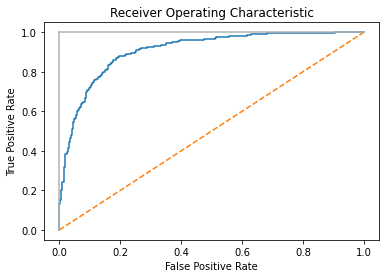

In [5]:
# Load libraries
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# Create feature matrix and target vector
features, target = make_classification(n_samples=10000,
                                       n_features=10,
                                       n_classes=2,
                                       n_informative=3,
                                       random_state=3)

# Split into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.1, random_state=1)

# Create classifier
logit = LogisticRegression()

# Train model
logit.fit(features_train, target_train)

# Get predicted probabilities
target_probabilities = logit.predict_proba(features_test)[:,1]

# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = roc_curve(target_test,
                                                               target_probabilities)

# Plot ROC curve
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

In [8]:
len(target_probabilities)

1000

### Discussion
Up until now we have only examined models based on the values they predict. However, in many learning algorithms those predicted values are based off of probability estimates. That is, each observation is given an explicit probability of belonging in each class. In our solution, we can use `predict_proba` to see the predicted probabilities for the first observation:

In [9]:
# Get predicted probabilities
logit.predict_proba(features_test)[0:1]

array([[0.86891533, 0.13108467]])

We can see the classes using `classes_`:

In [10]:
logit.classes_

array([0, 1])

In this example, the first observation has an ~87% chance of being in the negative class (0) and a 13% chance of being in the positive class (1). By default, scikit-learn predicts an observation is part of the positive class if the probability is greater than 0.5 (called the threshold). However, instead of a middle ground, we will often want to explicitly bias our model to use a different threshold for substantive reasons. For example, if a false positive is very costly to our company, we might prefer a model that has a high probability threshold. We fail to predict some positives, but when an observation is predicted to be positive, we can be very confident that the prediction is correct. This trade-off is represented in the true positive rate (TPR) and the false positive rate (FPR). The true positive rate is the number of observations correctly predicted true divided by all true positive observations:

$$ \text{TPR} = \frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$$

The false positive rate is the number of incorrectly predicted positives divided by all true negative observations:

$$ \text{FPR} = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}$$

The ROC curve represents the respective TPR and FPR for every probability threshold. For example, in our solution a threshold of roughly 0.50 has a TPR of 0.81 and an FPR of 0.15:

In [ ]:
print("Threshold:", threshold[116])
print("True Positive Rate:", true_positive_rate[116])
print("False Positive Rate:", false_positive_rate[116])

However, if we increase the threshold to ~80% (i.e., increase how certain the model has to be before it predicts an observation as positive) the TPR drops significantly but so does the FPR:

In [ ]:
print("Threshold:", threshold[45])
print("True Positive Rate:", true_positive_rate[45])
print("False Positive Rate:", false_positive_rate[45])

This is because our higher requirement for being predicted to be in the positive class has made the model not identify a number of positive observations (the lower TPR), but also reduce the noise from negative observations being predicted as positive (the lower FPR).

In addition to being able to visualize the trade-off between TPR and FPR, the ROC curve can also be used as a general metric for a model. The better a model is, the higher the curve and thus the greater the area under the curve. For this reason, it is common to calculate the area under the ROC curve (AUCROC) to judge the overall quality of a model at all possible thresholds. The closer the AUCROC is to 1, the better the model. In scikit-learn we can calculate the AUCROC using `roc_auc_score`:

In [ ]:
# Calculate area under curve
roc_auc_score(target_test, target_probabilities)

### See Also
* [ROC Curves in Python and R](https://community.alteryx.com/t5/Data-Science-Blog/ROC-Curves-in-Python-and-R/ba-p/138430)
* [The Area Under a ROC Curve](http://gim.unmc.edu/dxtests/roc3.htm)

## 6. Evaluating Multiclass Classifier Predictions


### Problem

You have a model that predicts three or more classes and want to evaluate its performance.
### Solution

Use cross-validation with an evaluation metric capable of handling more than two classes:

In [13]:
# Load libraries
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

# Generate features matrix and target vector
features, target = make_classification(n_samples = 10000,
                           n_features = 3,
                           n_informative = 3,
                           n_redundant = 0,
                           n_classes = 3,
                           random_state = 1)

# Create logistic regression
logit = LogisticRegression()

# Cross-validate model using accuracy
cross_val_score(logit, features, target, cv = 3, scoring='accuracy')

array([0.83503299, 0.82958296, 0.81278128])

### Discussion

When we have balanced classes (e.g., a roughly equal number of observations in each class of the target vector), accuracy is -- just like in the binary class setting -- a simple and interpretable choice for an evaluation metric. Accuracy is the number of correct predictions divided by the number of observations and works just as well in the multiclass as binary setting. However, when we have imbalanced classes (a common scenario), we should be inclined to use other evaluation metrics.

Many of scikit-learn’s built-in metrics are for evaluating binary classifiers. However, many of these metrics can be extended for use when we have more than two classes. Precision, recall, and $F_1$ scores are useful metrics that we have already covered in detail in previous exercises. While all of them were originally designed for binary classifiers, we can apply them to multiclass settings by treating our data as a set of binary classes. Doing so enables us to apply the metrics to each class as if it were the only class in the data, and then aggregate the evaluation scores for all the classes by averaging them:

In [14]:
# Cross-validate model using macro averaged F1 score
cross_val_score(logit, features, target,cv = 3, scoring='f1_macro')

array([0.83477937, 0.82931964, 0.81275734])

In this code, `_macro` refers to the method used to average the evaluation scores from the classes:

`macro`

    Calculate mean of metric scores for each class, weighting each class equally.
`weighted`

    Calculate mean of metric scores for each class, weighting each class proportional to its size in the data.
`micro`

    Calculate mean of metric scores for each observation-class combination.


## 7. Visualizing a Classifier's Performance

### Problem

Given predicted classes and true classes of the test data, you want to visually compare the model’s quality.
### Solution

Use a confusion matrix, which compares predicted classes and true classes:

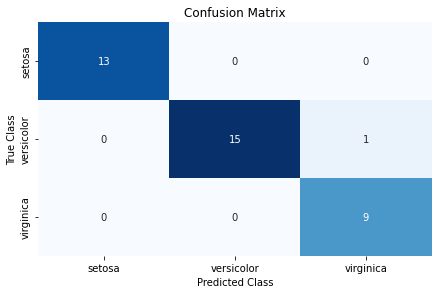

In [11]:
# Load libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

# Load data
iris = datasets.load_iris()

# Create feature matrix
features = iris.data

# Create target vector
target = iris.target

# Create list of target class names
class_names = iris.target_names

# Create training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=1)

# Create logistic regression
classifier = LogisticRegression(max_iter = 150)

# Train model and make predictions
target_predicted = classifier.fit(features_train,
    target_train).predict(features_test)

# Create confusion matrix
matrix = confusion_matrix(target_test, target_predicted)

# Create pandas dataframe
dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)

# Create heatmap
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix"), plt.tight_layout()
plt.ylabel("True Class"), plt.xlabel("Predicted Class")
plt.show()

### Discussion

Confusion matrices are an easy, effective visualization of a classifier’s performance. One of the major benefits of confusion matrices is their interpretability. Each column of the matrix (often visualized as a heatmap) represents predicted classes, while every row shows true classes. The end result is that every cell is one possible combination of predict and true classes. This is probably best explained using an example. In the solution, the top-left cell is the number of observations predicted to be Iris setosa (indicated by the column) that are actually Iris setosa (indicated by the row). This means the models accurately predicted all Iris setosa flowers. However, the model does not do as well at predicting Iris virginica. The bottom-right cell indicates that the model successfully predicted nine observations were Iris virginica, but (looking one cell up) predicted six flowers to be viriginica that were actually Iris versicolor.

There are three things worth noting about confusion matrices. First, a perfect model will have values along the diagonal and zeros everywhere else. A bad model will look like the observation counts will be spread evenly around cells. Second, a confusion matrix lets us see not only where the model was wrong, but also how it was wrong. That is, we can look at patterns of misclassification. For example, our model had an easy time differentiating Iris virginica and Iris setosa, but a much more difficult time classifying Iris virginica and Iris versicolor. Finally, confusion matrices work with any number of classes (although if we had one million classes in our target vector, the confusion matrix visualization might be difficult to read).

### See Also

* [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

* [scikit-learn documentation: Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)



## 8. Evaluating Regression Models

### Problem

You want to evaluate the performance of a regression model.
### Solution

Use mean squared error (MSE):

In [ ]:
# Load libraries
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Generate features matrix, target vector
features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   n_informative = 3,
                                   n_targets = 1,
                                   noise = 50,
                                   coef = False,
                                   random_state = 1)

# Create a linear regression object
ols = LinearRegression()

# Cross-validate the linear regression using (negative) MSE
cross_val_score(ols, features, target, cv = 3, scoring='neg_mean_squared_error')

Another common regression metric is the coefficient of determination, $R^2$

In [ ]:
# Cross-validate the linear regression using R-squared
cross_val_score(ols, features, target, cv = 3, scoring='r2')

### Discussion

MSE is one of the most common evaluation metrics for regression models. Formally, MSE is:

$$
\text{MSE} = \dfrac{1}{n} \sum_i^n = (\hat y_i − y_i)^2
$$

where $n$ is the number of observations, $y_i$ is the true value of the target we are trying to predict for observation $i$, and $\hat y_i$ is the model’s predicted value for $y_i$. MSE is a measurement of the squared sum of all distances between predicted and true values. The higher the value of MSE, the greater the total squared error and thus the worse the model. There are a number of mathematical benefits to squaring the error term, including that it forces all error values to be positive, but one often unrealized implication is that squaring penalizes a few large errors more than many small errors, even if the absolute value of the errors is the same. For example, imagine two models, A and B, each with two observations:

* Model A has errors of 0 and 10 and thus its MSE is $0^2 + 10^2 = 100$.

* Model B has two errors of 5 each, and thus its MSE is $5^2 + 5^2 = 50$.

Both models have the same total error, 10; however, MSE would consider Model A (MSE = 100) worse than Model B (MSE = 50). In practice this implication is rarely an issue (and indeed can be theoretically beneficial) and MSE works perfectly fine as an evaluation metric.

One important note: by default in scikit-learn arguments of the scoring parameter assume that higher values are better than lower values. However, this is not the case for MSE, where higher values mean a worse model. For this reason, scikit-learn looks at the negative MSE using the `neg_mean_squared_error` argument.

A common alternative regression evaluation metric is $R^2$, which measures the amount of variance in the target vector that is explained by the model:

$$
R^2 = 1 − \dfrac{\sum_{i=1}^n(y_i − \hat y_i)^2}{\sum^n_{i=1} (y_i − \bar y)^2}
$$

where $y_i$ is the true target value of the $i$th observation, $\hat y_i$ is the predicted value for the $i$th observation, and $\bar y$ is the mean value of the target vector. The closer to 1.0, the better the model.


### See Also

* [Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error)

* [Coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination)

## 9. Creating a Custom Evaluation Metric
### Problem

You want to evaluate a model using a metric you created.
### Solution

Create the metric as a function and convert it into a scorer function using scikit-learn’s `make_scorer`:

In [ ]:
# Load libraries
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

# Generate features matrix and target vector
features, target = make_regression(n_samples = 100,
                                   n_features = 3,
                                   random_state = 1)

# Create training set and test set
features_train, features_test, target_train, target_test = train_test_split(
     features, target, test_size=0.10, random_state=1)

# Create custom metric
def custom_metric(target_test, target_predicted):
    # Calculate r-squared score
    r2 = r2_score(target_test, target_predicted)
    # Return r-squared score
    return r2

# Make scorer and define that higher scores are better
score = make_scorer(custom_metric, greater_is_better=True)

# Create ridge regression object
classifier = Ridge()

# Train ridge regression model
model = classifier.fit(features_train, target_train)

# Apply custom scorer
score(model, features_test, target_test)

### Discussion

While scikit-learn has a number of built-in metrics for evaluating model performance, it is often useful to define our own metrics. scikit-learn makes this easy using `make_scorer`. First, we define a function that takes in two arguments -- the ground truth target vector and our predicted values -- and outputs some score. Second, we use `make_scorer` to create a scorer object, making sure to specify whether higher or lower scores are desirable (using the `greater_is_better` parameter).

The custom metric in the solution (custom_metric) is a toy example since it simply wraps a built-in metric for calculating the $R^2$ score. In a real-world situation, we would replace the `custom_metric` function with whatever custom metric we wanted. However, we can see that the custom metric that calculates $R^2$ does work by comparing the results to scikit-learn’s `r2_score` built-in method:

In [ ]:
# Predict values
target_predicted = model.predict(features_test)

# Calculate r-squared score
r2_score(target_test, target_predicted)


### See Also

* [scikit-learn documentation: make_scorer](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer)



## 10. Visualizing the Effect of Training Set Size

### Problem

You want to evaluate the effect of the number of observations in your training set on some metric (accuracy, $F_1$, etc.).
### Solution

Plot the learning curve:

In [ ]:
# Load libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve

# Load data
digits = load_digits()

# Create feature matrix and target vector
features, target = digits.data, digits.target

# Create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(# Classifier
                                                        RandomForestClassifier(),
                                                        # Feature matrix
                                                        features,
                                                        # Target vector
                                                        target,
                                                        # Number of folds
                                                        cv=10,
                                                        # Performance metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1,
                                                        # Sizes of 50
                                                        # training set
                                                       train_sizes=np.linspace(
                                                       0.01,
                                                       1.0,
                                                       50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"),
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### Discussion

Learning curves visualize the performance (e.g., accuracy, recall) of a model on the training set and during cross-validation as the number of observations in the training set increases. They are commonly used to determine if our learning algorithms would benefit from gathering additional training data.

In our solution, we plot the accuracy of a random forest classifier at 50 different training set sizes ranging from 1% of observations to 100%. The increasing accuracy score of the cross-validated models tell us that we would likely benefit from additional observations (although in practice this might not be feasible).

### See Also

* [scikit-learn documentation: Learning Curve](http://scikit-learn.org/stable/modules/learning_curve.html#learning-curve)

## 11. Creating a Text Report of Evaluation Metrics

### Problem

You want a quick description of a classifier’s performance.
### Solution

Use scikit-learn’s `classification_report`:

In [ ]:
# Load libraries
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data
iris = datasets.load_iris()

# Create feature matrix
features = iris.data

# Create target vector
target = iris.target

# Create list of target class names
class_names = iris.target_names

# Create training and test set
features_train, features_test, target_train, target_test = train_test_split(
    features, target, random_state=1)

# Create logistic regression
classifier = LogisticRegression(max_iter = 250)

# Train model and make predictions
model = classifier.fit(features_train, target_train)
target_predicted = model.predict(features_test)

# Create a classification report
print(classification_report(target_test,
                            target_predicted,
                            target_names=class_names))

### Discussion

`classification_report` provides a quick means for us to see some common evaluation metrics, including precision, recall, and $F_1$-score. Support refers to the number of observations in each class.

### See Also

* [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)



## 12. Visualizing the Effect of Hyperparameter Values

### Problem

You want to understand how the performance of a model changes as the value of some hyperparameter changes.
### Solution

Plot the validation curve:

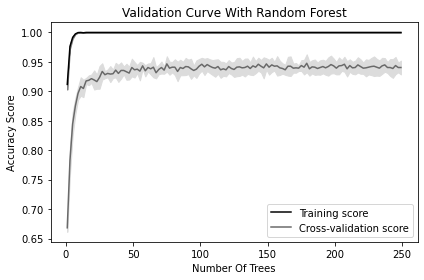

In [12]:
# Load libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import validation_curve

# Load data
digits = load_digits()

# Create feature matrix and target vector
features, target = digits.data, digits.target

# Create range of values for parameter
param_range = np.arange(1, 250, 2)

# Calculate accuracy on training and test set using range of parameter values
train_scores, test_scores = validation_curve(
    # Classifier
    RandomForestClassifier(),
    # Feature matrix
    features,
    # Target vector
    target,
    # Hyperparameter to examine
    param_name="n_estimators",
    # Range of hyperparameter's values
    param_range=param_range,
    # Number of folds
    cv=3,
    # Performance metric
    scoring="accuracy",
    # Use all computer cores
    n_jobs=-1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot mean accuracy scores for training and test sets
plt.plot(param_range, train_mean, label="Training score", color="black")
plt.plot(param_range, test_mean, label="Cross-validation score", color="dimgrey")

# Plot accurancy bands for training and test sets
plt.fill_between(param_range, train_mean - train_std,
                 train_mean + train_std, color="gray")
plt.fill_between(param_range, test_mean - test_std,
                 test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Validation Curve With Random Forest")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")
plt.tight_layout()
plt.legend(loc="best")
plt.show()

### Discussion

Most training algorithms (including many covered in this book) contain hyperparameters that must be chosen before the training process begins. For example, a random forest classifier creates a “forest” of decision trees, each of which votes on the predicted class of an observation. One hyperparameter in random forest classifiers is the number of trees in the forest. Most often hyperparameter values are selected during model selection. However, it is occasionally useful to visualize how model performance changes as the hyperparameter value changes. In our solution, we plot the changes in accuracy for a random forest classifier for the training set and during cross-validation as the number of trees increases. When we have a small number of trees, both the training and cross-validation score are low, suggesting the model is underfitted. As the number of trees increases to 250, the accuracy of both levels off, suggesting there is probably not much value in the computational cost of training a massive forest.

In scikit-learn, we can calculate the validation curve using `validation_curve`, which contains three important parameters:

* `param_name` is the name of the hyperparameter to vary.

* `param_range` is the value of the hyperparameter to use.

* `scoring` is the evaluation metric used to judge to model.

### See Also

* [scikit-learn documentation: Validation Curve](https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve)



In [15]:
np.arange(1, 10, 1)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])